In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
import numpy as np

In [91]:
# DATA
# data_supereasy = pd.read_parquet("data/super_easy/track2_data.parquet")
# print("supereasy data shape:", data_supereasy.shape)       
# print(data_supereasy.index.name)

In [92]:
# data_easy = pd.read_parquet("data/easy/track2_data.parquet")

In [93]:
data_hard = pd.read_parquet("data/hard/track2_data.parquet")

In [94]:
data = data_hard

In [ ]:
# sample = data_supereasy.loc[1.0]  
# channel_42 = data_supereasy[42]
print(data.head())

channel      0         1         2         3         4         5         6     \
time_s                                                                          
0.000   -0.051093 -0.075067 -0.071821  0.047007  0.065583 -0.071403 -0.043429   
0.002   -0.014788  0.064915 -0.061345 -0.064201 -0.204804  0.041109 -0.030799   
0.004   -0.104310  0.131012 -0.079911 -0.040412 -0.035540 -0.082277 -0.012245   
0.006    0.024137  0.028349 -0.063062  0.065412 -0.107557  0.015297  0.119255   
0.008    0.101000  0.037421  0.178894 -0.033641  0.092886  0.065804 -0.068984   

channel      7         8         9     ...      1014      1015      1016  \
time_s                                 ...                                 
0.000    0.017375 -0.026304  0.032438  ... -0.322092 -0.183421 -0.073924   
0.002   -0.129704 -0.049069 -0.059994  ... -0.192332 -0.175594 -0.052161   
0.004    0.167949  0.087458 -0.013116  ... -0.224483 -0.153954  0.067907   
0.006    0.080347  0.085558  0.058532  ...  0.643852

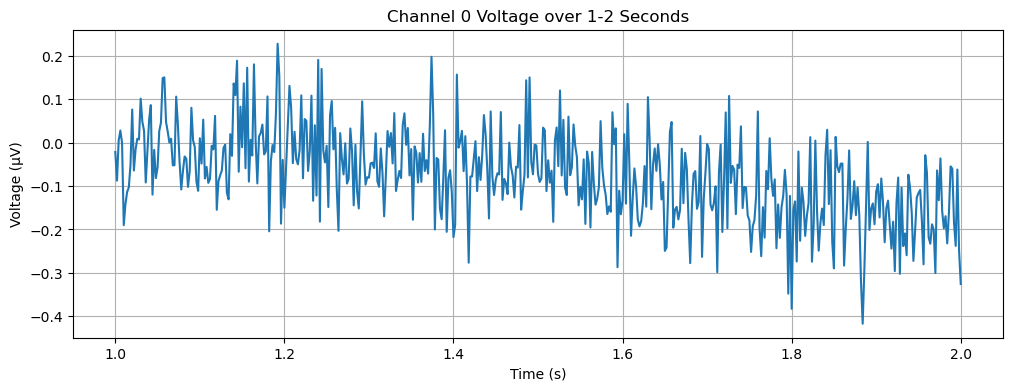

In [96]:
# EDA
channel_0 = data.loc[1:2, 0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0.index, channel_0.values)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

In [97]:
# BANDPASS FILTERING
def bandpass_filter(data, lowcut, highcut, fs=500, order=4):
    """Apply bandpass filter to extract frequency band of interest."""
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfiltfilt(sos, data, axis=0)

# Example: Extract high-gamma band (often motor-related)
filtered_highgamma = bandpass_filter(data, lowcut=70, highcut=150, fs=500)
filtered_theta = bandpass_filter(data, lowcut=4, highcut=12, fs=500)
filtered_beta = bandpass_filter(data, lowcut=12, highcut=30, fs=500)
filtered_lowgamma= bandpass_filter(data, lowcut=30, highcut=70, fs=500)

print("Filtered data shape:", filtered_highgamma.shape)

Filtered data shape: (150000, 1024)


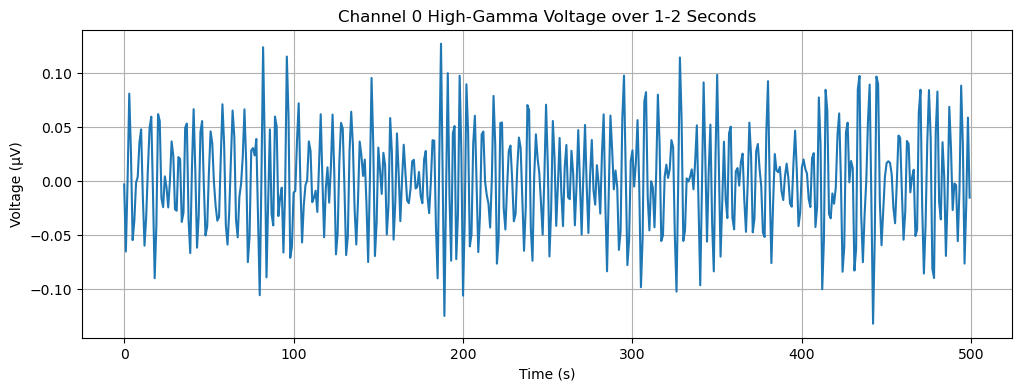

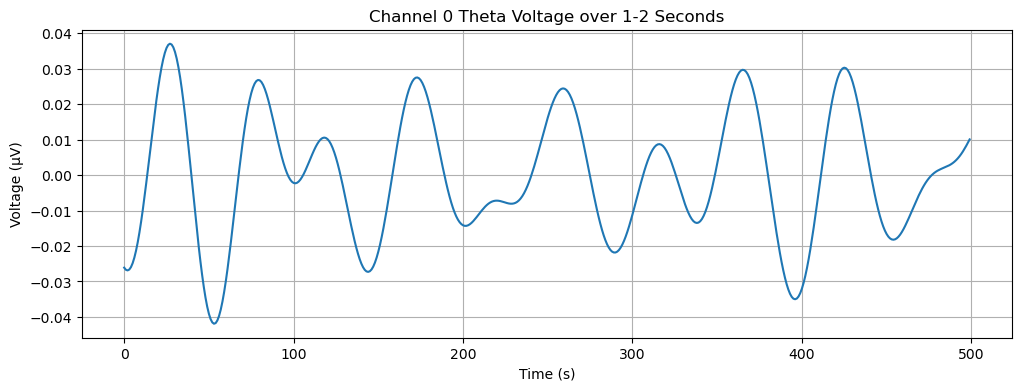

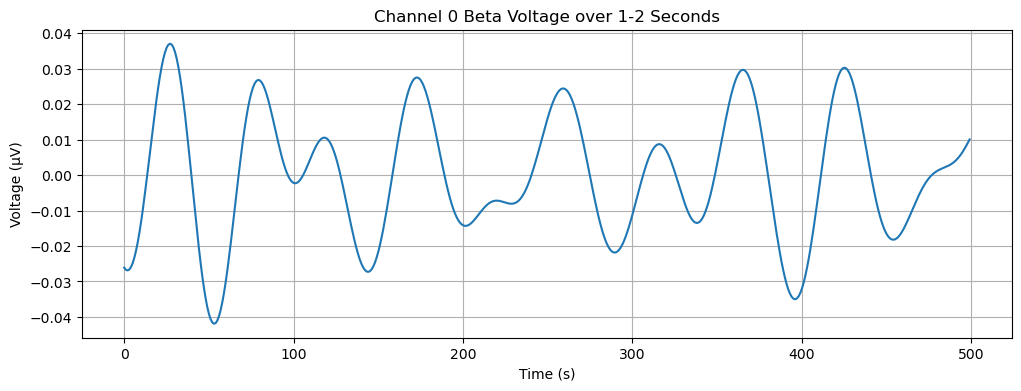

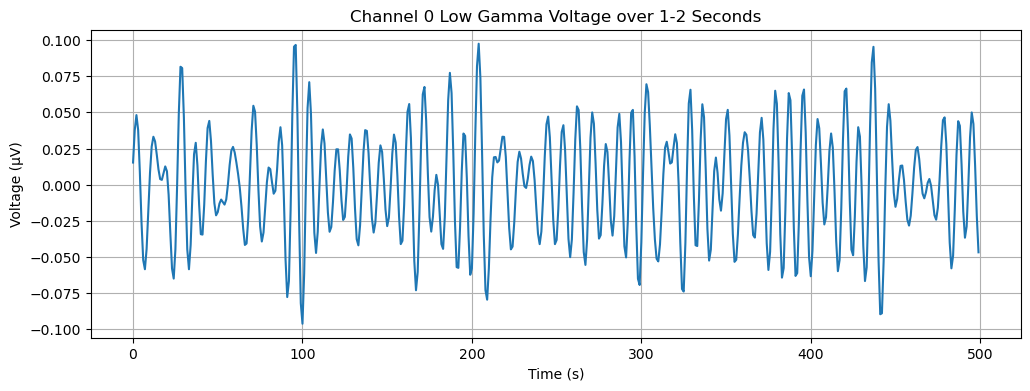

In [98]:
channel_0_highgamma= filtered_highgamma[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_highgamma)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 High-Gamma Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

channel_0_theta= filtered_theta[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_theta)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Theta Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

channel_0_beta= filtered_beta[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_theta)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Beta Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

channel_0_lowgamma= filtered_lowgamma[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_lowgamma)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Low Gamma Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

In [99]:
# POWER ESTIMATION
def compute_power(filtered_data, window_ms=100, fs=500):
    """
    Compute smoothed power envelope for multi-channel data.
    
    filtered_data: (n_samples, n_channels)
    Returns: smoothed_power of same shape
    """
    n_samples, n_channels = filtered_data.shape
    window_samples = int(window_ms * fs / 1000)
    kernel = np.ones(window_samples) / window_samples

    smoothed = np.zeros_like(filtered_data)
    
    for ch in range(n_channels):
        power = filtered_data[:, ch] ** 2
        smoothed[:, ch] = np.convolve(power, kernel, mode='same')
        
    return smoothed

power_highgamma = compute_power(filtered_highgamma)
print(power_highgamma.shape)

(150000, 1024)


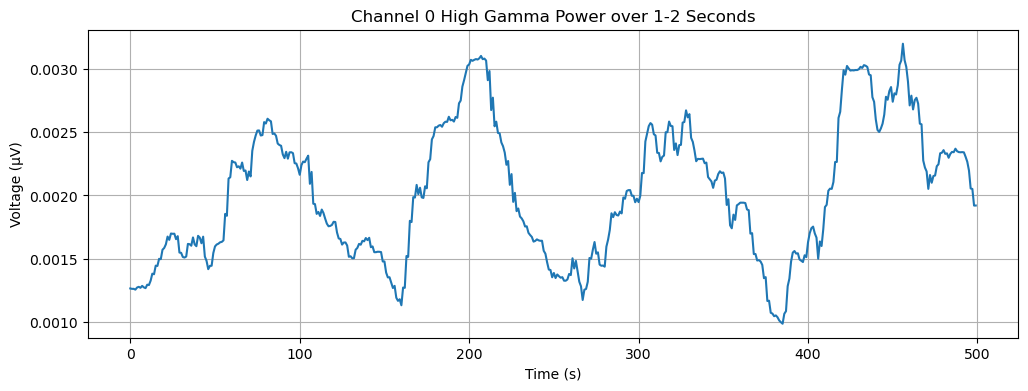

In [100]:
channel_0_power_highgamma = power_highgamma[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_power_highgamma)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 High Gamma Power over 1-2 Seconds')
plt.grid(True)
plt.show()

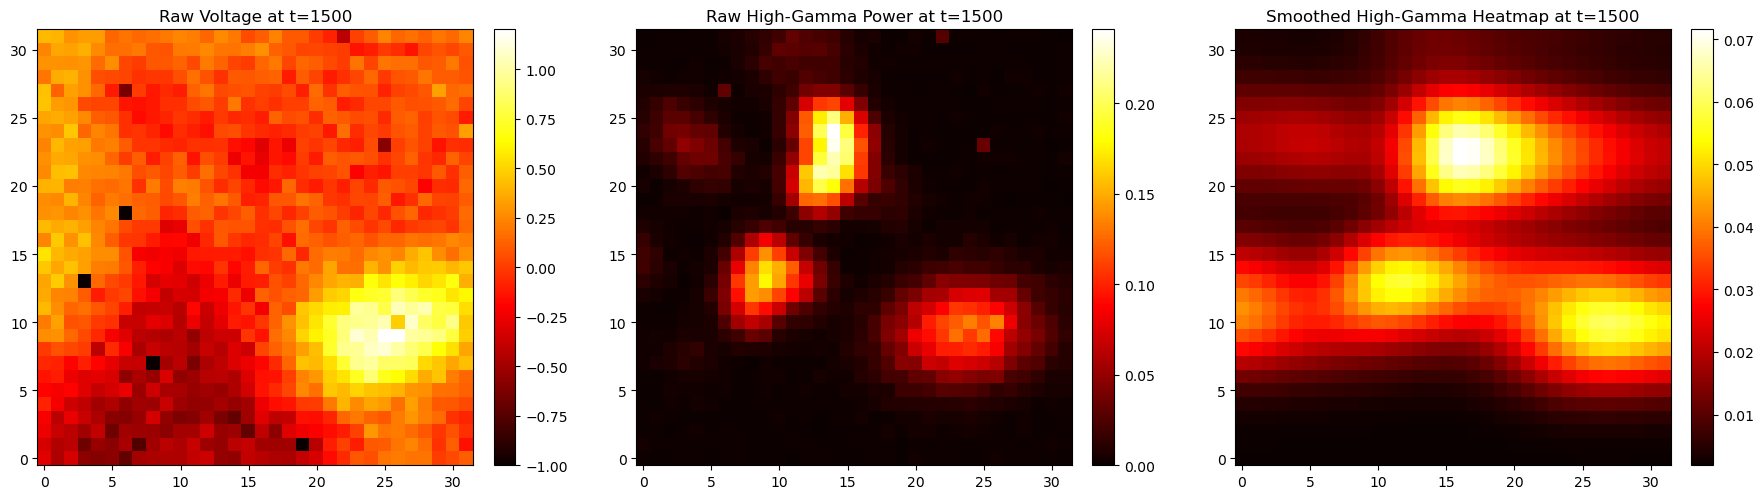

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# -----------------------------
# 1. Exponential smoothing class
# -----------------------------
class ExponentialSmoother:
    """Exponential moving average for real-time smoothing."""
    def __init__(self, alpha=0.1):
        self.alpha = alpha  # Higher = faster response, more noise
        self.state = None
    
    def update(self, new_value):
        if self.state is None:
            self.state = new_value
        else:
            self.state = self.alpha * new_value + (1 - self.alpha) * self.state
        return self.state

# -----------------------------
# 2. Spatial smoothing
# -----------------------------
def spatial_smooth(grid_data, sigma=1.5):
    """Apply Gaussian smoothing to 32x32 grid."""
    return gaussian_filter(grid_data.reshape(32, 32), sigma=sigma)

# -----------------------------
# 3. Pick one time point
# -----------------------------
t = 3*500  # sample index
channel_power = power_highgamma[t, :]  # raw power, shape (1024,)

# --- Temporal smoothing per channel ---
smoother = ExponentialSmoother(alpha=0.1)
smoothed_power = np.zeros_like(channel_power)
for ch in range(len(channel_power)):
    smoothed_power[ch] = smoother.update(channel_power[ch])

# --- Spatial smoothing ---
smoothed_heatmap = spatial_smooth(smoothed_power, sigma=1.5)

# -----------------------------
# 4. Plot raw vs smoothed side by side
# -----------------------------
# --- Raw voltage (32x32) ---
channel_raw = np.array(data.iloc[t, :])  # shape (1024,)
raw_grid = channel_raw.reshape(32, 32)

# --- Raw high-gamma power (32x32) ---
raw_power_grid = channel_power.reshape(32, 32)  # channel_power = power_highgamma[t, :]

# --- Smoothed high-gamma heatmap ---
# smoothed_heatmap already computed

# -----------------------------
# Plot all three side by side
# -----------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Raw voltage
im0 = axs[0].imshow(raw_grid, origin='lower', cmap='hot', interpolation='nearest')
axs[0].set_title(f'Raw Voltage at t={t}')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# 2. Raw high-gamma power
im1 = axs[1].imshow(raw_power_grid, origin='lower', cmap='hot', interpolation='nearest')
axs[1].set_title(f'Raw High-Gamma Power at t={t}')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# 3. Smoothed high-gamma heatmap
im2 = axs[2].imshow(smoothed_heatmap, origin='lower', cmap='hot', interpolation='nearest')
axs[2].set_title(f'Smoothed High-Gamma Heatmap at t={t}')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [102]:
# # GROUND TRUTH
# gt = pd.read_parquet("data/hard/ground_truth.parquet")

# # Cursor velocity
# vx, vy = gt['vx'], gt['vy']

# # Tuned region positions (row, col in 1-32 range)
# vx_pos_row = gt['vx_pos_center_row']
# vx_pos_col = gt['vx_pos_center_col']

In [103]:
# print(vx)
# print(vx_pos_row)
# print(vx_pos_col)